<a href="https://colab.research.google.com/github/zoetice/data-science/blob/main/Copy_of_Unit4ExerciesSF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import arviz as az
import pymc as pm

# Unit 4 Exercises: Tinkering Hierarchical Models

These exercises are designed to force you to look at the nuances of the models we looked at in class, while exploring some "what ifs". There's also some mild data wrangling for you to enjoy at in task6.



**Task1**:

Redo the chemical shift hierarchical model, execpt with all Student T  and Half Student T likelihood and priors.

Then, compare group posteriors of the normal chem shift model with your new Student T model using a ridge plot.

In [3]:
#load the data from my github page.
#cs stands for chemical shift data
url_cs = 'https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/chemical_shifts_theo_exp.csv'
#I could have put the url string directly into pd.read_csv()
cs_data = pd.read_csv(url_cs)

In [4]:
cs_data

,ID,aa,theo,exp,cat
0,1BM8,ILE,61.18,58.27,Non-Polar
1,1BM8,TYR,56.95,56.18,Polar
2,1BM8,SER,56.35,56.84,Polar
3,1BM8,ALA,51.96,51.01,Special
4,1BM8,ARG,56.54,54.64,Charged
...,...,...,...,...,...
1771,1KS9,LYS,55.79,57.51,Charged
1772,1KS9,ARG,58.91,59.02,Charged
1773,1KS9,LYS,59.49,58.92,Charged
1774,1KS9,GLU,59.48,58.36,Charged


In [5]:
#element wise subtraction
diff_TminusE = cs_data.theo - cs_data.exp
#adds a column called 'diff_TminusE' as the fifth column of cs_data
cs_data.insert(loc=4,column='diff_TminusE',value=diff_TminusE)

In [ ]:
aa_encode = pd.Categorical(cs_data['aa'])
aa_encode

In [ ]:
aa_idx = aa_encode.codes
aa_idx

In [ ]:
aa_coords = {"aa": aa_encode.categories}
aa_coords

In [ ]:
with pm.Model(coords=aa_coords) as cs_nh_model:
    #priors
    #dims="aa" means to apply the prior seperately to each amino acid
    μ = pm.StudentT('μ', nu=1, mu=0, sigma=10,
                  dims="aa")
    σ = pm.HalfStudentT('σ', nu=10, sigma=10,
                      dims="aa")

    #The idx variable tells my model which diffs belong to the same amino acid
    #this will cause my model to generate a posterior for each amino acid
    y = pm.Normal('y',
                  mu = μ[aa_idx],
                  sigma = σ[aa_idx],
                  observed=cs_data.diff_TminusE)

    #cs for chemshift, nh for nonheirarchical
    idata_cs_nh = pm.sample()

In [ ]:
with pm.Model(coords=aa_coords) as cs_h_model:
    # hyperpriors. Notice how there's no dims argument.
    #this means that the hyperprior is shared across all amino acids
    μ_mu = pm.StudentT('μ_mu', nu=30, mu = 0, sigma = 10)
    μ_sd = pm.HalfStudentT('μ_sd', nu=30, sigma = 10)
    μ_nu = pm.Exponential('μ_nu', lam=1/30)

    # priors. There is a different prior for each amino acid,
    #but now the μ priors 'talk' to one another through μ_mu and μ_sd
    μ = pm.StudentT('μ',
                  nu = μ_nu,
                  mu = μ_mu, # I include the hyperprior in my prior
                  sigma = μ_sd, # I include the hyperprior in my prior
                  dims = "aa")

    σ = pm.HalfStudentT('σ', nu = 30, sigma = 10,
                      dims = "aa")

    v = pm.Exponential('v', lam = 1/30, dims = "aa")

    #likelihood; same as before
    y = pm.StudentT('y', nu = v[aa_idx],
                  mu = μ[aa_idx], #I include the prior in my likelihood
                  sigma = σ[aa_idx], #I include the prior in my likelihood
                  observed = cs_data.diff_TminusE)

    #cs for chemshift, h for heirarchical
    idata_cs_h = pm.sample()

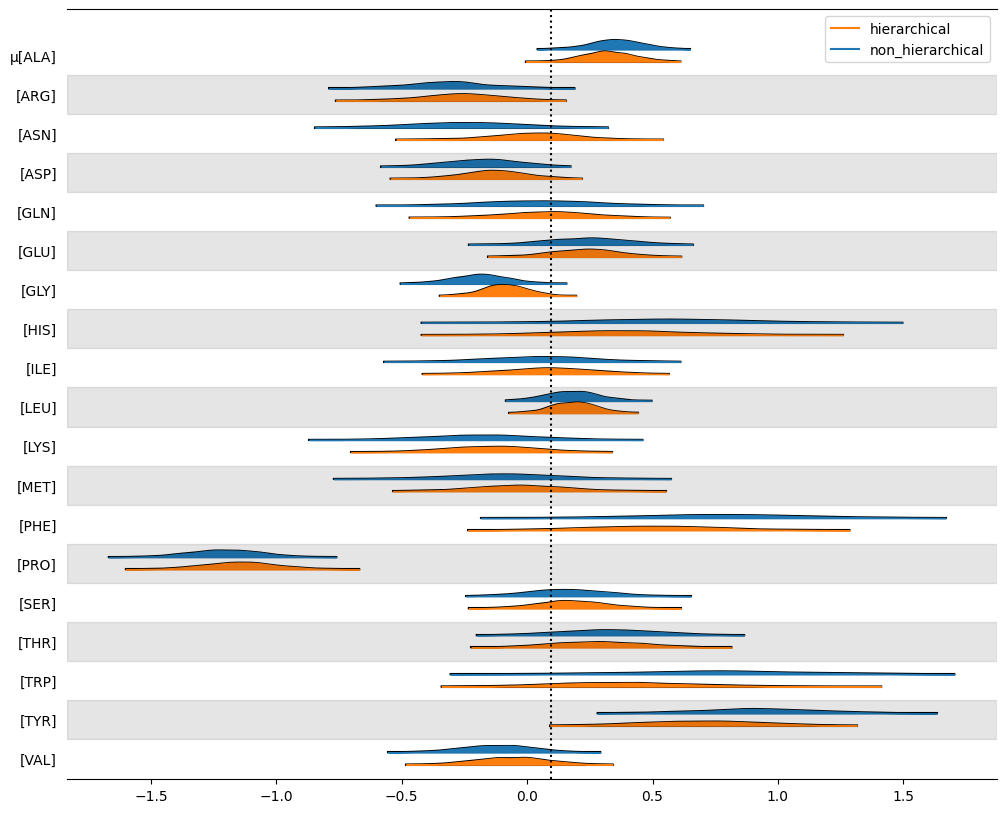

In [20]:
#plots a 99.7% hdi for the posteriors of both models on the same plot
axes = az.plot_forest([idata_cs_nh, idata_cs_h], kind="ridgeplot",
                      model_names=['non_hierarchical', 'hierarchical'],
                      var_names='μ', combined=True, figsize=(12, 10),hdi_prob=0.997)

#plots overall mean of the hierarchical model; do not confuse with 0
y_lims = axes[0].get_ylim()
axes[0].vlines(idata_cs_h.posterior['μ_mu'].mean(), *y_lims, color="k", ls=":");

**Task2**:

Run a posterior predictive check for both models. Which seems to fit the data better?

Output()

<Axes: xlabel='y'>

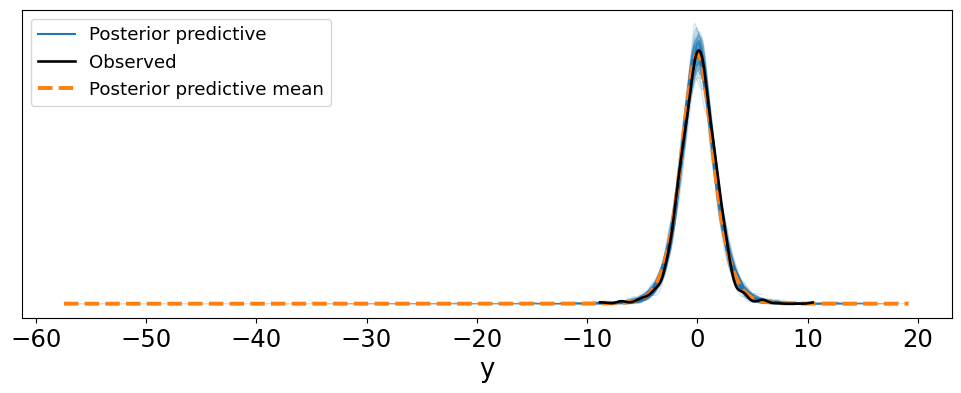

In [21]:
pm.sample_posterior_predictive(idata_cs_h, model=cs_h_model, extend_inferencedata=True)
az.plot_ppc(idata_cs_h, num_pp_samples=100, figsize=(12,4))

They both fit the data and look pretty similar, but I would go with StudentT.

**Task3**:

Redo the soccer model, but this time, assume the groups are independent. This will be a non-hierarchical model.

In [22]:
#load the data from my github page.
#sccr stands for soccer
url_sccr = 'https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/football_players.csv'

#Turns the position column into a categorical variable
sccr_data = pd.read_csv(url_sccr,dtype={'position':'category'})

In [23]:
#this is an array of the soccer positions,
#except they are given an int (number) label instead of a string (of letters)
pos_idx = sccr_data.position.cat.codes.values

#an array of the four strings that represent position
pos_codes = sccr_data.position.cat.categories

#puts coords in a dict, so pymc can read them
sccr_coords = {"pos": pos_codes}

In [ ]:
with pm.Model(coords = sccr_coords) as sccr_model:
    # Hyper parameters

    # Parameters for positions
    μ_p = pm.Beta('μ_p', mu = 2/(2+20), nu = 55, dims = "pos")

    ν_p = pm.Gamma('ν_p', mu = 55, sigma = 45, dims="pos")

    # Parameter for players
    θ = pm.Beta('θ', mu = μ_p[pos_idx], nu = ν_p[pos_idx])

    #This tells our model how many shots and goals each player has
    _ = pm.Binomial('gs',
                    n = sccr_data.shots.values, #shots for each player
                    p = θ, #guess of goals per shot
                    observed = sccr_data.goals.values) #goals per player

    #target_accept has a default of 0.8. Increasing it makes us less likely to
    #have divergences
    idata_sccr = pm.sample(target_accept = 0.95)

**Task4**:

Run plot trace and rhat on your inference data object for the non-hierarchical soccer model. How does this compare to the hierarchical model?

In [25]:
az.rhat(idata_sccr)

<xarray.Dataset> Size: 43kB
Dimensions:  (θ_dim_0: 2682, pos: 4)
Coordinates:
  * θ_dim_0  (θ_dim_0) int64 21kB 0 1 2 3 4 5 ... 2676 2677 2678 2679 2680 2681
  * pos      (pos) <U2 32B 'DF' 'FW' 'GK' 'MF'
Data variables:
    θ        (θ_dim_0) float64 21kB 1.001 0.9997 1.001 1.0 ... 1.001 1.002 1.001
    μ_p      (pos) float64 32B 1.008 1.001 1.032 1.0
    ν_p      (pos) float64 32B 1.006 1.002 1.099 1.007

array([[<Axes: title={'center': 'θ'}>, <Axes: title={'center': 'θ'}>],
       [<Axes: title={'center': 'μ_p'}>, <Axes: title={'center': 'μ_p'}>],
       [<Axes: title={'center': 'ν_p'}>, <Axes: title={'center': 'ν_p'}>]],
      dtype=object)

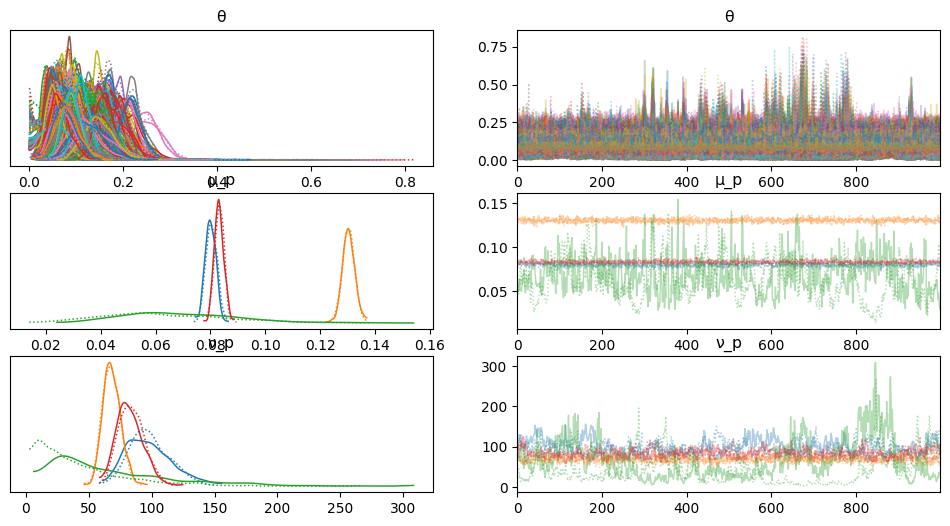

In [28]:
az.plot_trace(idata_sccr)

the non-hierarchial has different rhat values that are more than 1.001, but the hierarchal has values less than 1

**Task5**:

Plot the posterior of the means for each soccer position in the non-hierarchical model.

How do these posteriors compare to the hierarchical model we did in class?

it is a little less right leaning

array([<Axes: >], dtype=object)

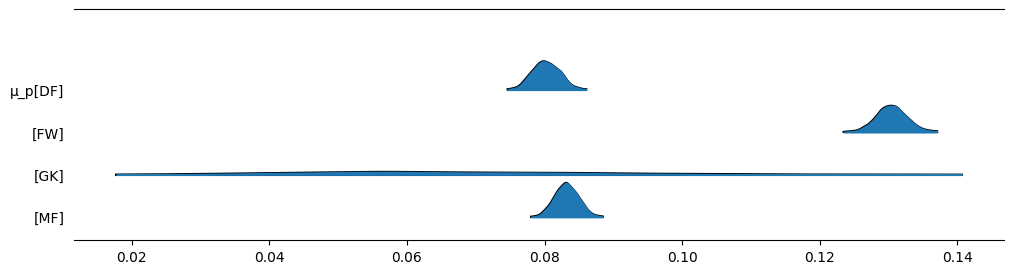

In [30]:
az.plot_forest(idata_sccr, var_names=['μ_p'], combined=True, figsize=(12, 3), kind = 'ridgeplot', hdi_prob=0.998)

**Task6**:

Redo the soccer model as a hierarchical model, but remove all the goalkeepers (GK) from the data. In other words, run a hierarchical model on only the defenders, midfielders, and forwards.

In [29]:
sccr_data_no_gk=sccr_data['position'] != 'GK'

In [ ]:
# Filter out goalkeepers from the data
# used gemini
sccr_data_no_gk = sccr_data[sccr_data['position'] != 'GK'].copy()

# Update position categorical codes and categories
sccr_data_no_gk['position'] = sccr_data_no_gk['position'].cat.remove_unused_categories()
pos_idx_no_gk = sccr_data_no_gk.position.cat.codes.values
pos_codes_no_gk = sccr_data_no_gk.position.cat.categories
sccr_coords_no_gk = {"pos": pos_codes_no_gk}

with pm.Model(coords=sccr_coords_no_gk) as sccr_h_model_no_gk:
    # Hyperpriors
    μ_p_mu = pm.Beta('μ_p_mu', mu=2/(2+20), nu=55)
    μ_p_nu = pm.Gamma('μ_p_nu', mu=55, sigma=45)

    # Priors for positions (hierarchical)
    μ_p = pm.Beta('μ_p', mu=μ_p_mu, nu=μ_p_nu, dims="pos")
    ν_p = pm.Gamma('ν_p', mu=55, sigma=45, dims="pos")

    # Parameter for players
    θ = pm.Beta('θ', mu=μ_p[pos_idx_no_gk], nu=ν_p[pos_idx_no_gk])

    # Likelihood
    _ = pm.Binomial('gs',
                    n=sccr_data_no_gk.shots.values,
                    p=θ,
                    observed=sccr_data_no_gk.goals.values)

    # Sample the model
    idata_sccr_h_no_gk = pm.sample(target_accept=0.95)

array([[<Axes: title={'center': 'θ'}>, <Axes: title={'center': 'θ'}>],
       [<Axes: title={'center': 'μ_p'}>, <Axes: title={'center': 'μ_p'}>],
       [<Axes: title={'center': 'μ_p_mu'}>,
        <Axes: title={'center': 'μ_p_mu'}>],
       [<Axes: title={'center': 'μ_p_nu'}>,
        <Axes: title={'center': 'μ_p_nu'}>],
       [<Axes: title={'center': 'ν_p'}>, <Axes: title={'center': 'ν_p'}>]],
      dtype=object)

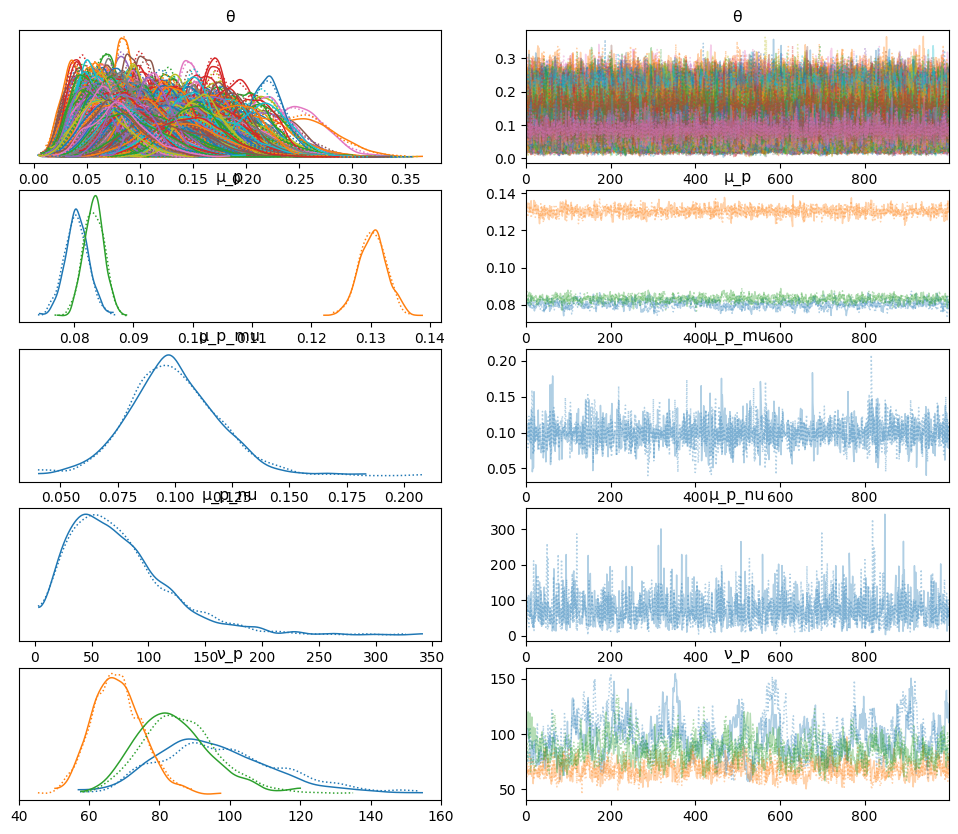

In [33]:
az.plot_trace(idata_sccr_h_no_gk)

**Task7**:

Compare the plot trace and rhat results for the hierarchical model with GKs and without GKs. Then answer the following questions:
- Which model was easier for pymc to process?
- What do we lose by dropping Gks from the data set? What do we gain?

The model without the GKs seemed easier for the pymc to process (although both took a while)

We lose the GK data but we gain more consistancy between the data and its shapes